In [199]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [200]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

In [201]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn import model_selection

In [202]:
train_df  = pd.read_csv("train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [203]:
test_df = pd.read_csv("test.csv")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [204]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [205]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [206]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [207]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [208]:
train_df[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [209]:
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)

In [210]:
combine = [train_df, test_df]

In [211]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [212]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [213]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping).astype(int)
    dataset['Title'] = dataset['Title'].fillna(0)

In [214]:
common_value = 'S'

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [215]:
for dataset in combine:
    age_avg 	   = dataset['Age'].mean()
    age_std 	   = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train_df['CategoricalAge'] = pd.cut(train_df['Age'], 5)

for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4
    
train_df[['Age', 'Survived']].groupby(['Age'], as_index=False).mean()

C:\Users\Manjesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Age,Survived
0,0,0.526316
1,1,0.355204
2,2,0.368627
3,3,0.434783
4,4,0.090909


In [216]:
for dataset in combine:
    dataset['Fare'] = dataset['Fare'].fillna(train_df['Fare'].median())
train_df['CategoricalFare'] = pd.qcut(train_df['Fare'], 4)


for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
train_df[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean()

,Fare,Survived
0,0,0.197309
1,1,0.308756
2,2,0.445415
3,3,0.581081


In [217]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [218]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [219]:
train_df = train_df.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
train_df = train_df.drop(['Name', 'PassengerId'], axis = 1)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,0,3,0,1,1,0,0,0,1,2,0
1,1,1,1,2,1,0,3,1,3,2,0
2,1,3,1,1,0,0,1,0,2,1,1
3,1,1,1,2,1,0,3,0,3,2,0
4,0,3,0,2,0,0,1,0,1,1,1


In [220]:
PassengerId = test_df['PassengerId']
test_df = test_df.drop(['Name', 'PassengerId'], axis = 1)
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,3,0,2,0,0,0,2,1,1,1
1,3,1,2,1,0,0,0,3,2,0
2,2,0,3,0,0,1,2,1,1,1
3,3,0,1,0,0,1,0,1,1,1
4,3,1,1,1,1,1,0,3,3,0


In [221]:
train_df = train_df.drop(['Parch', 'SibSp','FamilySize'], axis = 1)
test_df = test_df.drop(['Parch', 'SibSp','FamilySize'], axis = 1)

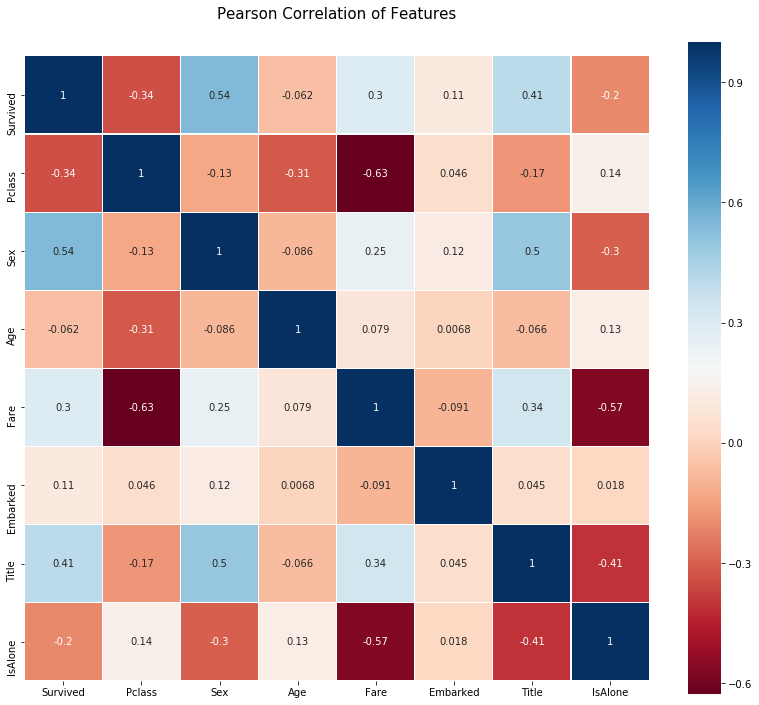

In [222]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [223]:
from sklearn.model_selection import train_test_split
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [224]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [225]:
gbc = GradientBoostingClassifier()
grid_values_gbc = {'n_estimators': [10, 50, 100, 500, 1000], 'max_depth':[3, 5, 7, 9], 'learning_rate':[0.01, 0.05, 0.1, 0.2]}
grid_clf_gbc = GridSearchCV(gbc, param_grid = grid_values_gbc, scoring = 'accuracy', cv =5)
grid_clf_gbc.fit(X_train_sc, y_train)
gbc = grid_clf_gbc.best_estimator_

In [226]:
from sklearn.svm import SVC
svc = SVC(probability=True)
grid_values_svc = {'C': [0.01, 0.1, 1, 5, 10, 15, 20, 50], 'gamma':[0.001, 0.01, 0.1, 0.2, 0.4, 0.8]}
grid_clf_svc = GridSearchCV(svc, param_grid = grid_values_svc, scoring = 'accuracy', cv =5)
grid_clf_svc.fit(X_train_sc, y_train)
svc = grid_clf_svc.best_estimator_

In [227]:
lr = LogisticRegression(solver='liblinear')
penalty = ['l2', 'l1']
C = np.logspace(0, 4, 10, 15, 20)
grid_values_lr = {'penalty': penalty, 'C': C}
grid_clf_lr = GridSearchCV(lr, param_grid = grid_values_lr, scoring = 'accuracy', cv =5)
grid_clf_lr.fit(X_train_sc, y_train)
lr = grid_clf_lr.best_estimator_

In [228]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
n_estimators = [10, 50, 100, 250, 500, 1000]
grid_values_xgb = {'learning_rate': learning_rate, 'n_estimators': n_estimators}
grid_clf_xgb = GridSearchCV(xgb, param_grid = grid_values_xgb, scoring = 'accuracy', cv =5)
grid_clf_xgb.fit(X_train_sc, y_train)
xgb = grid_clf_xgb.best_estimator_

In [229]:
max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
min_child_weight = [1, 2, 3, 4, 5, 6]
grid_values_xgb = {'max_depth': max_depth, 'min_child_weight': min_child_weight}
grid_clf_xgb = GridSearchCV(xgb, param_grid = grid_values_xgb, scoring = 'accuracy', cv =5)
grid_clf_xgb.fit(X_train_sc, y_train)
xgb = grid_clf_xgb.best_estimator_

In [230]:
gamma = [i*0.1 for i in range(0,5)]
grid_values_xgb = {'gamma': gamma}
grid_clf_xgb = GridSearchCV(xgb, param_grid = grid_values_xgb, scoring = 'accuracy', cv =5)
grid_clf_xgb.fit(X_train_sc, y_train)
xgb = grid_clf_xgb.best_estimator_

In [231]:
subsample = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
colsample_bytree = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
grid_values_xgb = {'subsample': subsample, 'colsample_bytree': colsample_bytree}
grid_clf_xgb = GridSearchCV(xgb, param_grid = grid_values_xgb, scoring = 'accuracy', cv =5)
grid_clf_xgb.fit(X_train_sc, y_train)
xgb = grid_clf_xgb.best_estimator_

In [232]:
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
grid_values_xgb = {'reg_alpha': reg_alpha}
grid_clf_xgb = GridSearchCV(xgb, param_grid = grid_values_xgb, scoring = 'accuracy', cv =5)
grid_clf_xgb.fit(X_train_sc, y_train)
xgb = grid_clf_xgb.best_estimator_

In [233]:
knn = KNeighborsClassifier()
n_neighbors = [1, 2, 3, 4, 5]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = [1, 2, 3, 4, 5, 10]
grid_values_knn = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
grid_clf_knn = GridSearchCV(knn, param_grid = grid_values_knn, scoring = 'accuracy', cv =5)
grid_clf_knn.fit(X_train_sc, y_train)
knn = grid_clf_knn.best_estimator_

C:\Users\Manjesh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [234]:
ada = AdaBoostClassifier()
n_estimators = [10, 100, 200, 500]
learning_rate = [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2]
grid_values_ada = {'n_estimators': n_estimators, 'learning_rate': learning_rate}
grid_clf_ada = GridSearchCV(ada, param_grid = grid_values_ada, scoring = 'accuracy', cv =5)
grid_clf_ada.fit(X_train_sc, y_train)
ada = grid_clf_ada.best_estimator_

C:\Users\Manjesh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [235]:
rfc = RandomForestClassifier()
n_estimators = [10, 50, 100, 200]
max_depth = [3, 5, 7]
max_features = [0.1, 0.2, 0.5, 0.8]
min_samples_split = [2, 6]
min_samples_leaf = [2, 6]
grid_values_rfc = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
grid_clf_rfc = GridSearchCV(rfc, param_grid = grid_values_rfc, scoring = 'accuracy', cv =5)
grid_clf_rfc.fit(X_train_sc, y_train)
rfc = grid_clf_rfc.best_estimator_

In [236]:
etc = ExtraTreesClassifier()
n_estimators = [10, 50, 100, 200]
max_depth = [3, 5, 7]
max_features = [0.1, 0.2, 0.5, 0.8]
min_samples_split = [2, 6]
min_samples_leaf = [2, 6]
grid_values_etc = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
grid_clf_etc = GridSearchCV(rfc, param_grid = grid_values_etc, scoring = 'accuracy', cv =5)
grid_clf_etc.fit(X_train_sc, y_train)
etc = grid_clf_etc.best_estimator_

In [237]:
bgc = BaggingClassifier()
n_estimators = [10, 50, 75, 100, 200]
max_samples = [0.1, 0.2, 0.5, 0.8, 1.0]
max_features = [0.1, 0.2, 0.5, 0.8, 1.0]
grid_values_bgc = {'n_estimators': n_estimators, 'max_samples': max_samples, 'max_features': max_features}
grid_clf_bgc = GridSearchCV(bgc, param_grid = grid_values_bgc, scoring = 'accuracy', cv =5)
grid_clf_bgc.fit(X_train_sc, y_train)
bgc = grid_clf_bgc.best_estimator_

C:\Users\Manjesh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [238]:
gnb = GaussianNB()

In [260]:
models = [rfc, lr, xgb, gbc, etc, ada, gnb, svc, knn, bgc]
model_name = ['Random Forest', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'Extra Trees','AdaBoost', 'Naive Bayes', 
              'Support Vector Machine', 'K Nearest Neighbors', 'Bagging Classifier']
df_yt = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10])
for i, mod in enumerate(models):
    acc = cross_val_score(mod, X_train_sc, y_train, scoring = "accuracy", cv = 5)
    mod.fit(X_train_sc, y_train)
    y_pred = mod.predict(X_test_sc)
    df_yt[i+1]=y_pred
    acc_test = accuracy_score(y_test, y_pred)
    print(model_name[i], 'Train Acc = ', acc.mean(), 'Test Acc = ', acc_test)

Random Forest Train Acc =  0.8019663684632219 Test Acc =  0.8044692737430168
Logistic Regression Train Acc =  0.7978300792205497 Test Acc =  0.776536312849162
XGBoost Train Acc =  0.8215860455596745 Test Acc =  0.8156424581005587
Gradient Boosting Train Acc =  0.8230146139945361 Test Acc =  0.7988826815642458
Extra Trees Train Acc =  0.8075707630697142 Test Acc =  0.7877094972067039
AdaBoost Train Acc =  0.8019462507325856 Test Acc =  0.7988826815642458
Naive Bayes Train Acc =  0.7626669404913337 Test Acc =  0.776536312849162
Support Vector Machine Train Acc =  0.8244330537108482 Test Acc =  0.7821229050279329
K Nearest Neighbors Train Acc =  0.7963227163406965 Test Acc =  0.8268156424581006
Bagging Classifier Train Acc =  0.7977901231722029 Test Acc =  0.7932960893854749


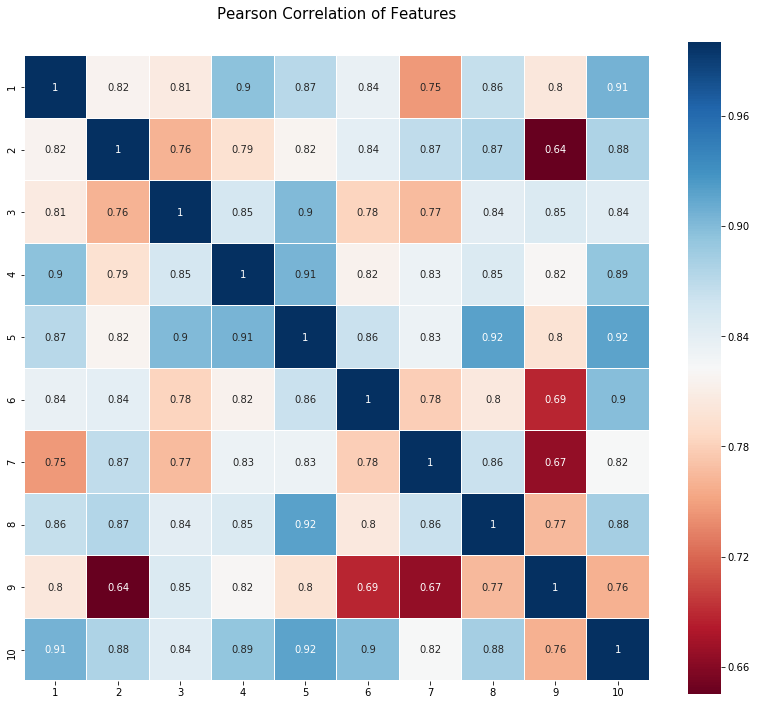

In [261]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_yt.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [244]:
grid_hard = VotingClassifier(estimators = [('Random Forest', rfc), 
                                           ('XGBoost', xgb),
                                           ('Gradient Boosting', gbc),
                                           ('SVC', svc),
                                           ('K Nearest Neighbour', knn),
                                           ('Bagging Classifier', bgc)], voting = 'hard')

scores_hd = cross_val_score(grid_hard, X_train_sc, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores_hd)
print("Mean:", scores_hd.mean())

Scores: [0.84722222 0.77777778 0.75       0.93055556 0.84507042 0.8028169
 0.74647887 0.77464789 0.74285714 0.91428571]
Mean: 0.8131712497205454


In [245]:
grid_hard.fit(X_train_sc, y_train)
y_gd_hd = grid_hard.predict(X_test_sc)
print('Accuracy:', accuracy_score(y_test, y_gd_hd))

Accuracy: 0.7932960893854749


In [246]:
grid_soft = VotingClassifier(estimators = [('Random Forest', rfc), 
                                           ('XGBoost', xgb),
                                           ('Gradient Boosting', gbc),
                                           ('SVC', svc),
                                           ('K Nearest Neighbour', knn),
                                           ('Bagging Classifier', bgc)], voting = 'soft')

scores_sf = cross_val_score(grid_soft, X_train_sc, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores_sf)
print("Mean:", scores_sf.mean())

Scores: [0.84722222 0.76388889 0.75       0.90277778 0.84507042 0.8028169
 0.8028169  0.77464789 0.78571429 0.91428571]
Mean: 0.8189241001564944


In [247]:
grid_soft.fit(X_train_sc, y_train)
y_gd_sf = grid_soft.predict(X_test_sc)
print('Accuracy:', accuracy_score(y_test, y_gd_sf))

Accuracy: 0.7932960893854749


In [250]:
y_pred = grid_soft.predict(scaler.transform(test_df))
sub_en = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': y_pred })
sub_en.to_csv("sub_en.csv", index=False)